In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import pathlib
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
index = 0
data_path = '/kaggle/input/medical-mnist'

# Storing all the labels(Which are also the subdirectories) in the form of a list.
paths = [os.path.join(data_path, name) for name in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, name))]
print(paths)  

#Storing all the labels in a list.
labell = []
for path in paths:
    label = path.split("/")[-1]  # Split the path by "/" and access the second-to-last element
    labell.append(label)

print(labell)

['/kaggle/input/medical-mnist/AbdomenCT', '/kaggle/input/medical-mnist/BreastMRI', '/kaggle/input/medical-mnist/Hand', '/kaggle/input/medical-mnist/CXR', '/kaggle/input/medical-mnist/HeadCT', '/kaggle/input/medical-mnist/ChestCT']
['AbdomenCT', 'BreastMRI', 'Hand', 'CXR', 'HeadCT', 'ChestCT']


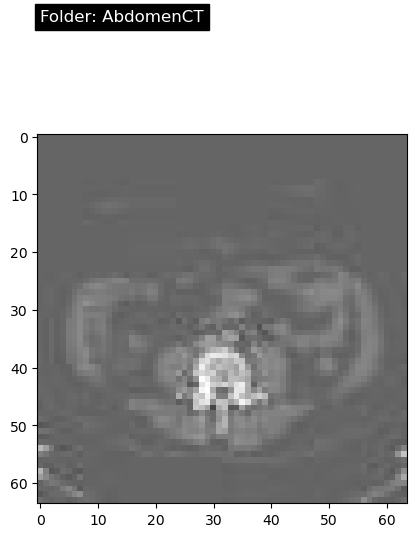

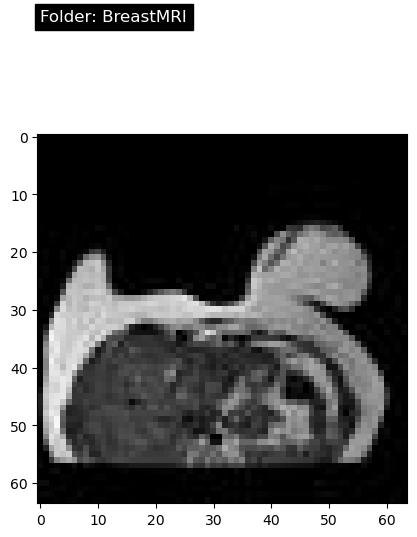

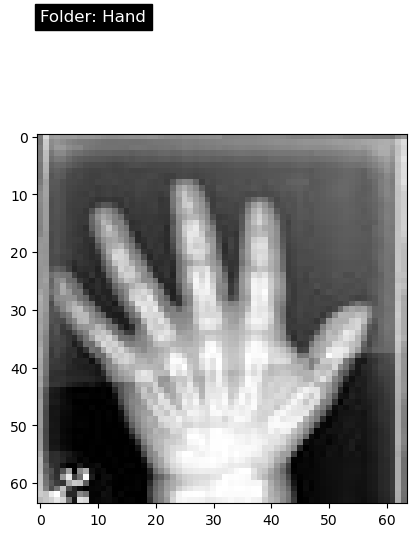

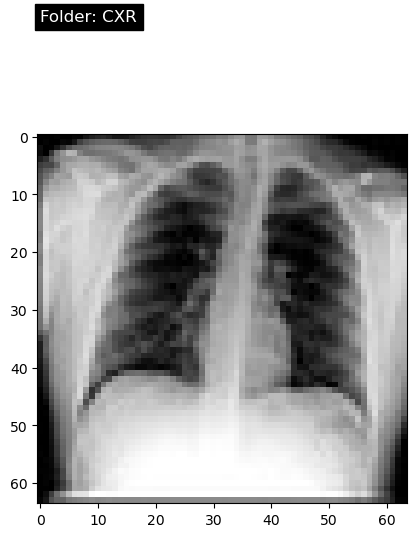

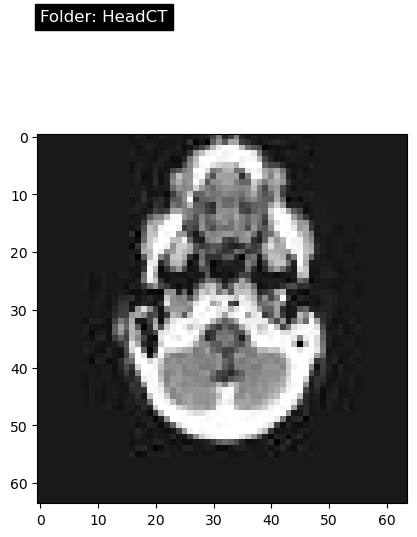

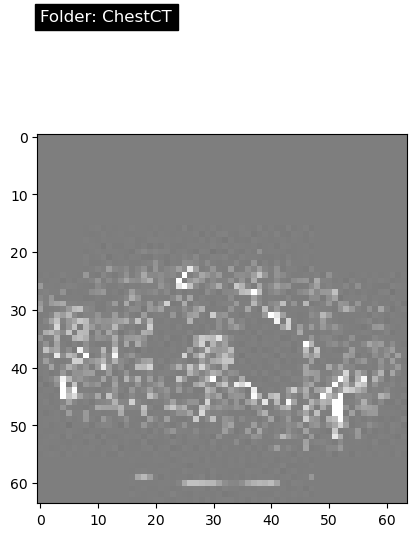

In [3]:
#Visualizing the Data.
for subdir in paths:
    image_files = os.listdir(subdir)
    if image_files:  # Check if there are any image files in the subdirectory
        image_path = os.path.join(subdir, image_files[0])  # Access the first image file
        image = cv2.imread(image_path)
        
        folder_name = os.path.basename(subdir)
        
        plt.imshow(image)
        plt.text(0, -20, f'Folder: {folder_name}', color='white', fontsize=12, backgroundcolor='black')
        plt.show()

In [4]:
files_path = []
files_labels = []

for root, dirs, files in os.walk(data_path):
  p = pathlib.Path(root)
  
  for file in files:
    files_path.append(root + '/' + file)
    files_labels.append(p.parts[-1])
    
len(files_path), len(files_labels)

(58954, 58954)

AbdomenCT 10000
BreastMRI 8954
Hand 10000
CXR 10000
HeadCT 10000
ChestCT 10000


<BarContainer object of 6 artists>

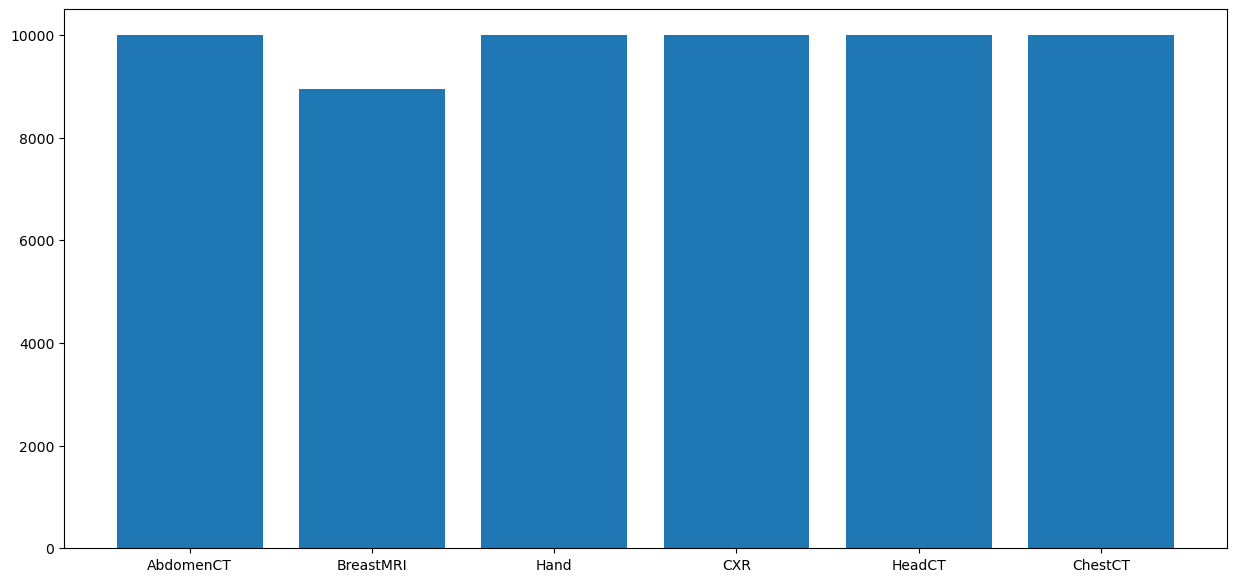

In [5]:
label_count = []
for label in labell:
  print(label, files_labels.count(label))
  label_count.append(files_labels.count(label))
    
#Plotting a label vs label_count graph.
plt.figure(figsize=(15, 7))
plt.bar(labell, label_count)

In [6]:
from keras.utils import to_categorical

IMG_SIZE = (64,64)
classes = len(labell)

# Initialize lists to store preprocessed images and labels
preprocessed_images = []
labels = []

# Resize and normalize images
for file_path, label in zip(files_path, files_labels):
    # Read image in grayscale
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

    # Resize image
    image = cv2.resize(image, IMG_SIZE)

    # Normalize pixel values to [0, 1]
    image = image.astype('float32') / 255.0

    # Append preprocessed image and label to lists
    preprocessed_images.append(image)
    labels.append(label)

# Convert lists to NumPy arrays
preprocessed_images = np.array(preprocessed_images)
labels = np.array(labels)


label_mapping = {'AbdomenCT': 0, 'BreastMRI': 1, 'Hand': 2, 'CXR': 3, 'HeadCT': 4, 'ChestCT': 5}

# Convert labels to numerical values
labels_numeric = [label_mapping[label] for label in files_labels]

# Perform one-hot encoding of labels
labels_onehot = to_categorical(labels_numeric, num_classes=classes)

#Shuffling the data to introduce randomness.
shuffle_indices = np.random.permutation(len(preprocessed_images))
shuffled_images = preprocessed_images[shuffle_indices]
shuffled_labels = labels_onehot[shuffle_indices]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    shuffled_images, shuffled_labels, test_size=0.15, random_state=42)

# Print the shapes of the preprocessed data
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (50110, 64, 64)
y_train shape: (50110, 6)
X_test shape: (8844, 64, 64)
y_test shape: (8844, 6)


In [7]:
# Define the model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='softmax'))  # Output layer with 6 units and softmax activation
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#callbacks
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=1)
tensorboard_callback = TensorBoard(log_dir='logs', histogram_freq=1)
model_checkpoint_callback = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)


# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test), callbacks =[early_stopping_callback, tensorboard_callback, model_checkpoint_callback])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 9216)              0

1/1 [==============================] - 0s 211ms/step
Predicted Class: Hand


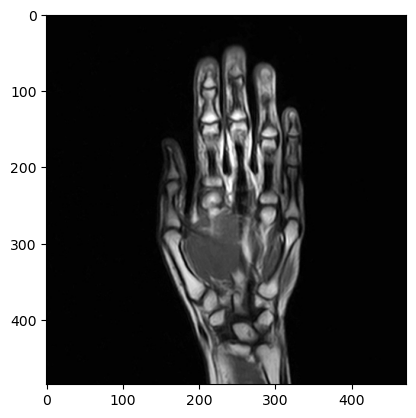

In [8]:
from keras.models import load_model

# Load the saved model
model = load_model('best_model.h5')

# Load and preprocess the external image
external_image_path = '/kaggle/input/hand-ct/HAND CORONAL.jpg'  # Replace with the path to your external image
external_image = cv2.imread(external_image_path, cv2.IMREAD_GRAYSCALE)
external_image = cv2.resize(external_image, (64, 64))
external_image = external_image.astype('float32') / 255.0
external_image = np.expand_dims(external_image, axis=-1)

# Reshape the external image
external_image = external_image.reshape(1, 64, 64, 1)

# Make predictions
predictions = model.predict(external_image)

# Get the predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# Map predicted labels to class names
class_mapping = {0: 'AbdomenCT', 1: 'BreastMRI', 2: 'Hand', 3: 'CXR', 4: 'HeadCT', 5: 'ChestCT'}
predicted_classes = [class_mapping[label] for label in predicted_labels]

# Print the predicted class
hand = cv2.imread('/kaggle/input/hand-ct/HAND CORONAL.jpg')
plt.imshow(hand)
print("Predicted Class:", predicted_classes[0])


In [10]:
to_Pred = X_test.reshape((8844, 64, 64,1))

277/277 [==============================] - 1s 2ms/step


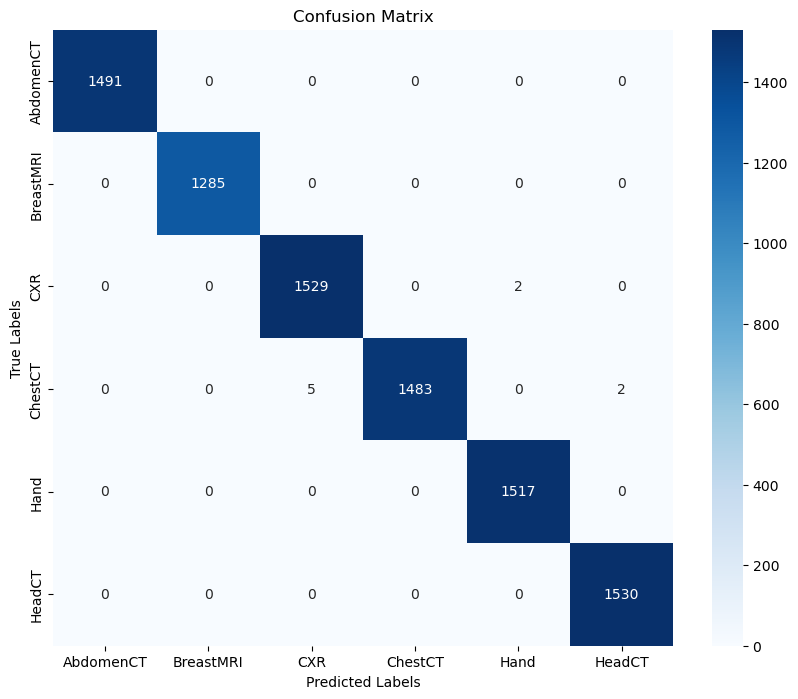

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

pred = model.predict(to_Pred)
y_pred = pred.argmax(axis=1).tolist()

rounded_labels=np.argmax(y_test, axis=1)

class_names = ['AbdomenCT', 'BreastMRI','CXR','ChestCT','Hand','HeadCT']
# Compute confusion matrix
cm = confusion_matrix(rounded_labels, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
